In [1]:
%pip install matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install scikit-learn



     ---------------------------------------- 0.0/104.6 kB ? eta -:--:--
     ----------- --------------------------- 30.7/104.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 104.6/104.6 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB 18.4 MB/s eta 0:00:01
   --- ------------------------------------ 0.7/8.1 MB 7.8 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/8.1 MB 8.8 MB/s eta 0:00:01
   ------ --------------------------------- 1.4/8.1 MB 8.1 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/8.1 MB 8.1 MB/s eta 0:00:01
   ---------- ----------------------------- 2.2/8.1 MB 7.6 MB/s eta 0:00:01
   ----------- ---------------------------- 2.4/8.1 MB 7.6 MB/s eta 0:00:01
   ------------- ---

In [2]:
import torch

print("CUDA disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))


CUDA disponible : True
Nom du GPU : NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
import os
import urllib.request
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

os.makedirs("oxford_pets", exist_ok=True)
os.chdir("oxford_pets")

urls = {
    "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
}

for name, url in urls.items():
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()

os.chdir("..")

for root, _, files in os.walk("oxford_pets/images"):
    for file in files:
        if file.endswith(".mat"):
            os.remove(os.path.join(root, file))

In [6]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
        self.transform = transform
        self.mask_transform = T.Resize((128, 128))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = np.array(mask)
        mask = (mask == 2).astype(np.float32)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = OxfordPetsDataset("oxford_pets/images", "oxford_pets/annotations/trimaps", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader


class SARDatasetNpy(Dataset):
    def __init__(self, images_dir, masks_dir, size=(128, 128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".npy")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        image = TF.resize(image, self.size, interpolation=TF.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=TF.InterpolationMode.NEAREST)

        mask = (mask > 0).float()
        return image, mask


train_dataset = SARDatasetNpy("data/sar_data_amplitude/", "data/labels_1c/")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
train_dataset = OxfordPetsDataset("data/sar_data_amplitude/", "data/labels_1c/", transform=transform)
#Peut-être augmenter la taille de batch car + de 6000 images dans le dataset MSTAR, à tester
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) 

In [4]:
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(256, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

In [5]:
# === Entraînement ===
model = UNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} processed", flush=True)

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Batch 0/1719 processed
Batch 10/1719 processed
Batch 20/1719 processed
Batch 30/1719 processed
Batch 40/1719 processed
Batch 50/1719 processed
Batch 60/1719 processed
Batch 70/1719 processed
Batch 80/1719 processed
Batch 90/1719 processed
Batch 100/1719 processed
Batch 110/1719 processed
Batch 120/1719 processed
Batch 130/1719 processed
Batch 140/1719 processed
Batch 150/1719 processed
Batch 160/1719 processed
Batch 170/1719 processed
Batch 180/1719 processed
Batch 190/1719 processed
Batch 200/1719 processed
Batch 210/1719 processed
Batch 220/1719 processed
Batch 230/1719 processed
Batch 240/1719 processed
Batch 250/1719 processed
Batch 260/1719 processed
Batch 270/1719 processed
Batch 280/1719 processed
Batch 290/1719 processed
Batch 300/1719 processed
Batch 310/1719 processed
Batch 320/1719 processed
Batch 330/1719 processed
Batch 340/1719 processed
Batch 350/1719 processed
Batch 360/1719 processed
Batch 370/1719 processed
Batch 380/1719 processed
Batch 390/1719 processed
Batch 400/1

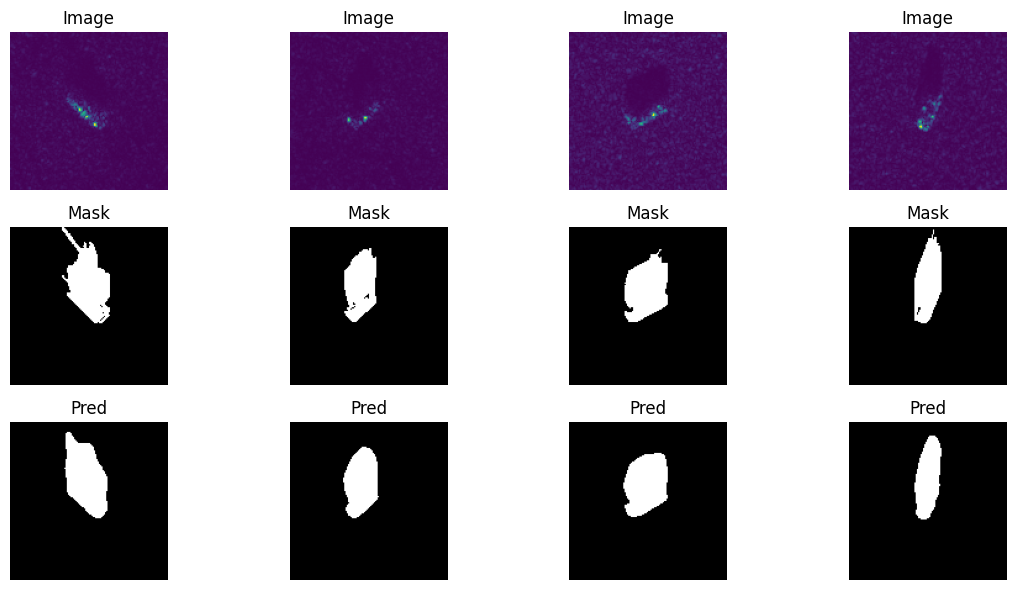

In [7]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images = images.to(device)
    masks = masks.to(device)
    preds = model(images)

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0).cpu())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    plt.imshow(masks[i][0].cpu(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    plt.imshow(preds[i][0].cpu().numpy() > 0.5, cmap='gray')
    plt.title("Pred")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import jaccard_score
import numpy as np

model.eval()
iou_scores = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        preds = model(images)
        preds = (preds > 0.5).float()

        for i in range(images.size(0)):
            pred_flat = preds[i][0].cpu().numpy().flatten()
            mask_flat = masks[i][0].cpu().numpy().flatten()
            iou = jaccard_score(mask_flat, pred_flat, average='binary')
            iou_scores.append(iou)

print(f"Mean IoU over dataset: {np.mean(iou_scores):.4f}")

Mean IoU over dataset: 0.8708
